<a href="https://colab.research.google.com/github/Yuanranzhu/SINN/blob/main/FPU_chain_SINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!hostname

gnode014.cluster


In [2]:
!nvidia-smi

Thu Feb  8 11:48:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA H100 PCIe               Off | 00000000:A8:00.0 Off |                    0 |
| N/A   28C    P0              48W / 350W |      4MiB / 81559MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)
import time

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device('cuda')

In [6]:
print(torch.__version__)
print(torch.version.cuda)

2.0.1+cu118
11.8


In [7]:
seed = 1234
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [8]:
%%time

######### Generating SINN training data by solving SDE
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad



###### Parameters 
mag=1              # Magnitude of the coupling
beta=1             # Inverse temperature 
alpha=1            
gamma=1            # Anharmonic potential U(x)=alpha/2* x^2  + gamma/4* x^4
N=100              # Total number of oscillators in the chain 
N_mid=int(N/2)     # Coordinate of the center CG-oscillator 
dt=0.01 
delta_t=0.5
batch = 400
sec_length = 400

Time = 5*delta_t*sec_length
print(Time)
length=int(Time/dt)+1
t = np.linspace(0,Time,length) # define time axis
gap=int(delta_t/dt)
t_store=t[0:-1:gap]



# (q25,q75)
q25_store = np.zeros([t_store.size+1,batch])    
q75_store = np.zeros([t_store.size+1,batch])

q=np.zeros((1,length)) 

p1=np.zeros((N,batch))
q1=np.zeros((N,batch))
p0=np.zeros((N,batch))
q0=np.zeros((N,batch))

# solve SDE

j=1
for i in range(1,length):
    q1=q0+dt*(p0-np.roll(p0,1,axis=0))
    p1=(1-mag*dt)*p0+dt*alpha*(np.roll(q0,-1,axis=0)-q0)+dt*gamma*(np.roll(q0,-1,axis=0)**3-q0**3)+np.sqrt(2*dt*gamma/beta)*np.random.randn(N,batch)
    if i % gap ==0:        
        q25_store[j,:]= np.sum(q1[0:25,:], axis=0)
        q75_store[j,:]= np.sum(q1[0:75,:], axis=0)
        j=j+1
    p0=p1
    q0=q1
                                
Toss=int(t_store.size/4)
q25_store=q25_store[Toss:-1,:] 
q75_store=q75_store[Toss:-1,:] 

1000.0
CPU times: user 9min 9s, sys: 20.4 ms, total: 9min 9s
Wall time: 9min 10s


Text(0.5, 1.0, 'Solution of the FPU chain dynamics $q_{25}$ and $q_{75}$')

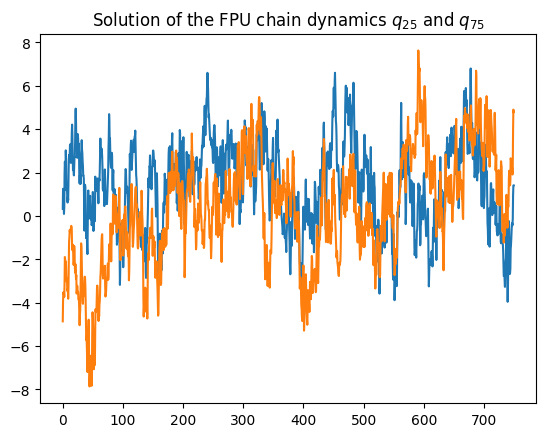

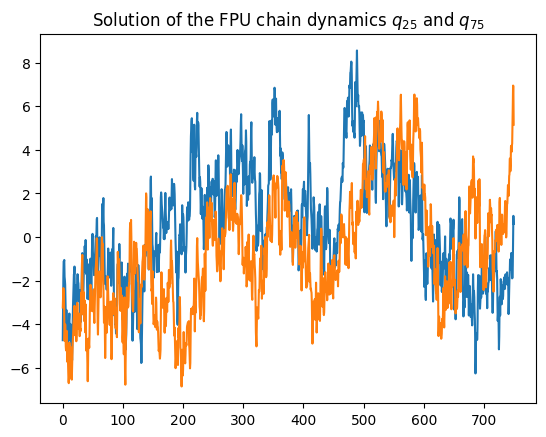

In [9]:
plt.figure(0)
plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,0])
plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,0])
plt.title(r"Solution of the FPU chain dynamics $q_{25}$ and $q_{75}$")

plt.figure(1)
plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,1])
plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,1])
plt.title(r"Solution of the FPU chain dynamics $q_{25}$ and $q_{75}$")

(400, 400) (400, 400) (400, 400)
(400, 400) (400, 400, 2)


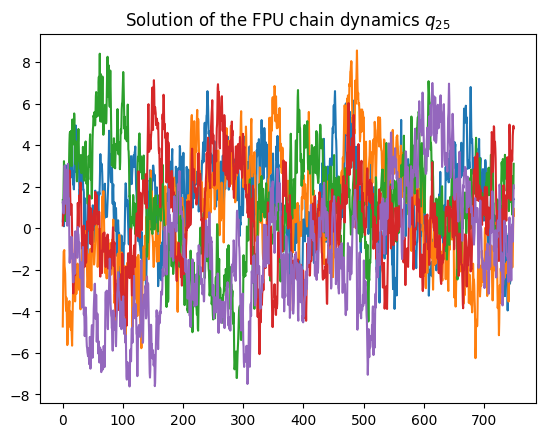

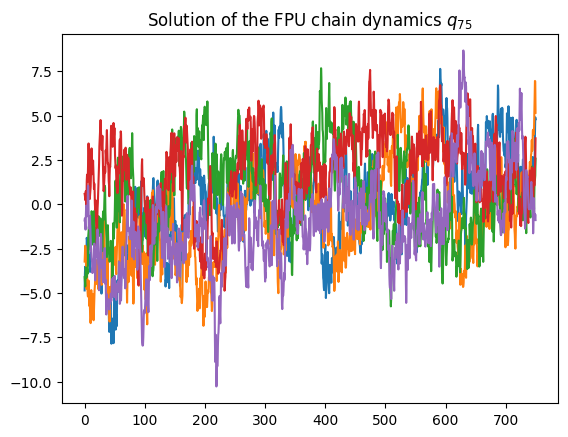

In [10]:
plt.figure(0)
for i in range(5):
    plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,i])
plt.title(r"Solution of the FPU chain dynamics $q_{25}$")

plt.figure(1)
for i in range(5):
    plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,i])
plt.title(r"Solution of the FPU chain dynamics $q_{75}$")

###########################################   Construct the sample traj for the LSTM learning 
ini=np.random.randn(sec_length,batch)
Traj25 = q25_store[0:sec_length,:]
Traj75 = q75_store[0:sec_length,:]
print(ini.shape, Traj25.shape, Traj75.shape)

Traj = np.empty((sec_length,batch,2))
Traj[:,:,0] = Traj25
Traj[:,:,1] = Traj75
T=np.arange(len(Traj[:,1]))*delta_t
x=np.linspace(-5,5,sec_length)
print(ini.shape, Traj.shape)

In [11]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 2)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 2), device=device)


Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 2]) torch.float32
The torch validation size is torch.Size([800, 400, 2]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


In [12]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_sec_moment = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_ccf_fft = make_loss('ccf[fft]', target, lags=LAGS, device=device)
loss_ccf_sec_moment = make_loss('ccf[fft]', target**2, lags=LAGS, device=device)
loss_ccf_bruteforce = make_loss('ccf[bruteforce]', target, lags=LAGS, device=device)
loss_ccf_randbrute = make_loss('ccf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_pdf_empirical1 = make_loss('pdf', target, lower=-5, upper=5, n=N, bw=None, device=device)
loss_pdf_empirical2 = make_loss('pdf6', target, lower=-5, upper=5, n=N, bw=None, device=device)
loss_pdf_empirical2D = make_loss('pdf2D', target, lower=-5, upper=5, n=N, bw=None, device=device)

torch.Size([400, 2])


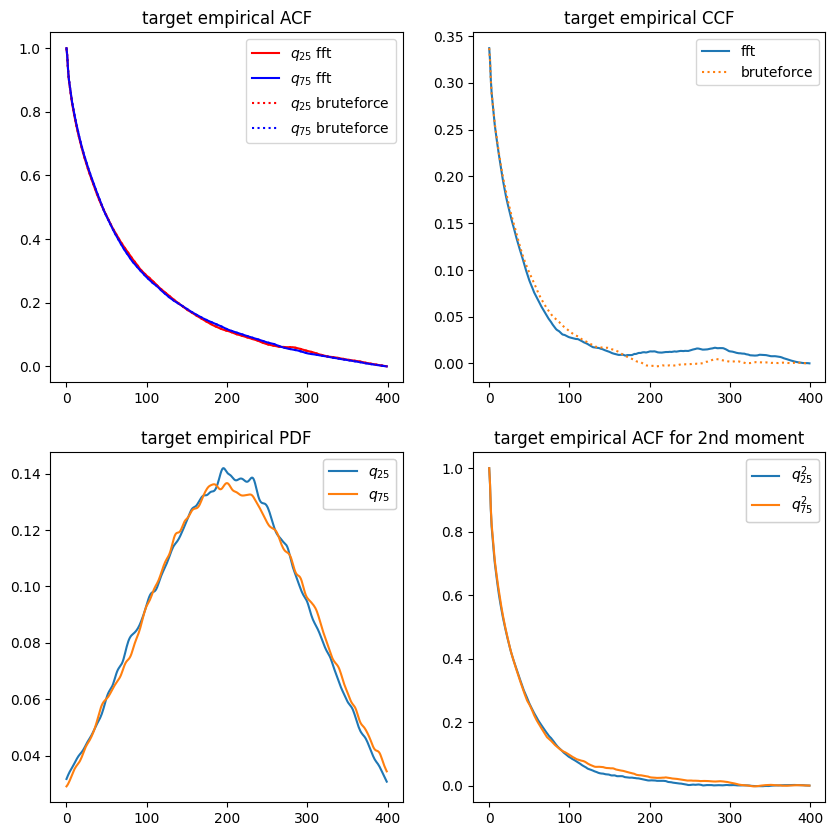

In [13]:
# Plotting target ACFs and PDF
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].plot(loss_acf_fft._target.cpu()[...,0],'r', label=r'$q_{25}$ fft')
axs[0,0].plot(loss_acf_fft._target.cpu()[...,1],'b', label=r'$q_{75}$ fft')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,0],'r:', label= r'$q_{25}$ bruteforce')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,1], 'b:', label=r'$q_{75}$ bruteforce')
axs[0,0].legend()
axs[0,0].set_title('target empirical ACF')

axs[0,1].plot(loss_ccf_fft._target.cpu()[...,1:3], label='fft')
axs[0,1].plot(loss_ccf_bruteforce._target.cpu()[...,1:3],':',label='bruteforce')
# legend2 = axs[0,1].legend(iter(bf), ('q bf', 'p bf'), loc=1)
# axs[0,1].add_artist(legend2)
axs[0,1].legend()
axs[0,1].set_title('target empirical CCF')

x_grid=-np.linspace(-5,5,num=sec_length)
pdf = axs[1,0].plot(loss_pdf_empirical1._target.cpu())
legend3 = axs[1,0].legend(iter(pdf), (r'$q_{25}$',r'$q_{75}$'), loc=1)
axs[1,0].add_artist(legend3)
axs[1,0].set_title('target empirical PDF')


print(loss_acf_sec_moment._target.cpu().size())
sec_moment = axs[1,1].plot(loss_acf_sec_moment._target.cpu())
legend4 = axs[1,1].legend(iter(sec_moment), (r'$q_{25}^2$',r'$q_{75}^2$'),loc=1)
axs[1,1].set_title('target empirical ACF for 2nd moment')
axs[1,1].add_artist(legend4)

plt.show()

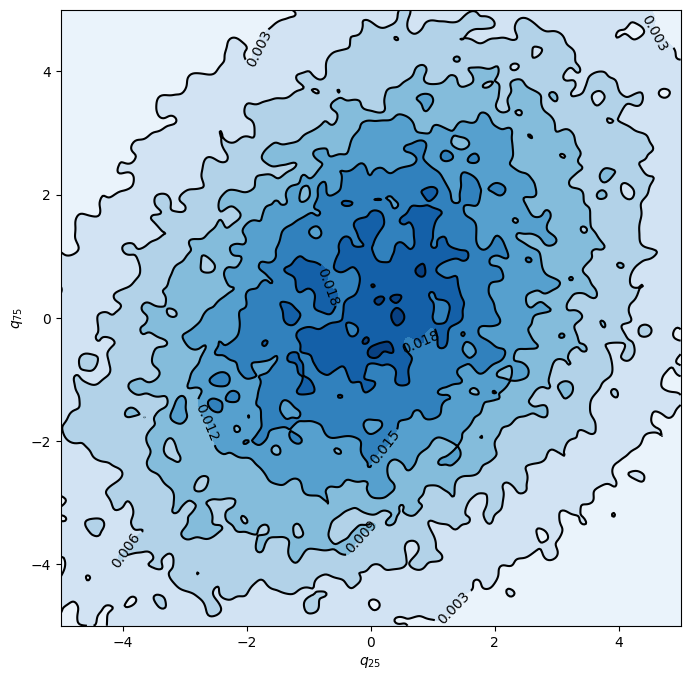

In [14]:
xmin, xmax = -5, 5
ymin, ymax = -5, 5

xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Contourf plot
cfset = ax.contourf(xx, yy, loss_pdf_empirical2D._target.cpu(), cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot

# Contour plot
cset = ax.contour(xx, yy, loss_pdf_empirical2D._target.cpu(), colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel(r'$q_{25}$')
ax.set_ylabel(r'$q_{75}$')

plt.show()

Text(0.5, 1.0, 'target empirical PDF')

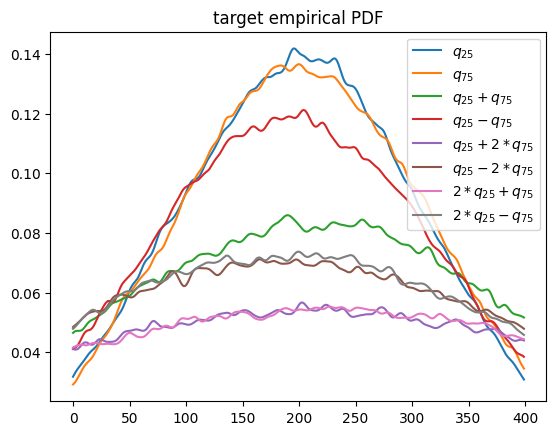

In [15]:
x_grid=-np.linspace(-5,5,num=sec_length)
plt.plot(loss_pdf_empirical1._target.cpu()[...,0],label=r'$q_{25}$')
plt.plot(loss_pdf_empirical1._target.cpu()[...,1],label=r'$q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,0],label=r'$q_{25}+q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,1],label=r'$q_{25}-q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,2],label=r'$q_{25}+2*q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,3],label=r'$q_{25}-2*q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,4],label=r'$2*q_{25}+q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,5],label=r'$2*q_{25}-q_{75}$')
plt.legend()
plt.title('target empirical PDF')

In [16]:
class Model:
    def __init__(self, net):

        self.x_acf_s = None
        self.x_ccf_s = None
        self.x_pdf_s = None
        self.x_pdf2_s = None
        self.x_acf2_s = None
        self.s_collect = []

        self.net = net

        self.T_error=[]
        self.V_error=[]
        self.T_ccf=[]
        self.V_ccf=[]
        self.T_pdf=[]
        self.V_pdf=[]
        self.T_pdf2=[]
        self.V_pdf2=[]
        self.T_acf=[]
        self.V_acf=[]
        self.T_acf2=[]
        self.V_acf2=[]
        self.Step=[]
        self.iter = 0
        self.time = 0

    def train_U(self, x):
        return self.net(x)

    def predict_U(self, x):
        return self.train_U(x)

    def likelihood_loss(self, loss_acf, loss_ccf, loss_pdf, loss_pdf2, loss_acf2):
        loss = torch.reciprocal(2. * self.x_acf_s ** 2) * loss_acf.detach()      \
               + torch.reciprocal(2. * self.x_ccf_s ** 2) * loss_ccf.detach()    \
               + torch.reciprocal(2. * self.x_pdf_s ** 2) * loss_pdf.detach()    \
               + torch.reciprocal(2. * self.x_pdf2_s ** 2) * loss_pdf2.detach()  \
               + torch.reciprocal(2. * self.x_acf2_s ** 2) * loss_acf2.detach()  \
               + torch.log(self.x_acf_s * self.x_ccf_s * self.x_pdf_s * self.x_pdf2_s * self.x_acf2_s)
        return loss

    def true_loss(self, loss_acf, loss_ccf, loss_pdf, loss_pdf2, loss_acf2):
        return torch.reciprocal(2. * self.x_acf_s.detach() ** 2) * loss_acf + torch.reciprocal(2. * self.x_ccf_s.detach() ** 2) * loss_ccf + torch.reciprocal(2. * self.x_pdf_s.detach() ** 2) * loss_pdf + torch.reciprocal(2. * self.x_pdf2_s.detach() ** 2) * loss_pdf2 + torch.reciprocal(2. * self.x_acf2_s.detach() ** 2) * loss_acf2

    def run_baseline(self):
        optimizer_adam = optim.Adam(self.net.parameters(), lr=1e-3)
        for step in range(20000):
            optimizer_adam.zero_grad()
            ini = np.random.randn(2*sec_length, batch*self.net.lstm.input_size).astype(np.float32) 
            input = torch.from_numpy(ini.reshape(2*sec_length, batch, self.net.lstm.input_size)).to(device)
            prediction, _ = self.train_U(input)
            prediction = prediction[-LAGS:,:,:]
            loss = loss_acf_fft(prediction)+ loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
            loss.backward()
            optimizer_adam.step()
            self.iter += 1
            if step % 50 == 0: 
                with torch.no_grad():
                    loss = loss_acf_fft(prediction)+loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
                    pred_val, _ = self.predict_U(val_set)
                    pred_val = pred_val[-LAGS:,:,:]
                    loss_val = loss_acf_bruteforce(pred_val)+loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical1(pred_val)+ loss_pdf_empirical2(pred_val) + loss_acf_sec_moment(pred_val**2)
                    acf = loss_acf_bruteforce(pred_val)
                    ccf = loss_ccf_bruteforce(pred_val)
                    pdf = loss_pdf_empirical1(pred_val)
                    pdf2 = loss_pdf_empirical2(pred_val)
                    acf_sec_moment = loss_acf_sec_moment(pred_val**2)
                    print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, ccf: %.5f, pdf: %.5f, pdf2: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, ccf, pdf, pdf2, acf_sec_moment))
                    self.T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
                    self.V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                    self.V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_pdf.append(loss_pdf_empirical1(prediction).detach().cpu().numpy())
                    self.V_pdf.append(loss_pdf_empirical1(pred_val).detach().cpu().numpy())
                    self.T_pdf2.append(loss_pdf_empirical2(prediction).detach().cpu().numpy())
                    self.V_pdf2.append(loss_pdf_empirical2(pred_val).detach().cpu().numpy())
                    self.T_acf2.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                    self.V_acf2.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                    self.T_error.append(loss.detach().cpu().numpy())
                    self.V_error.append(loss_val.detach().cpu().numpy())
                    self.Step.append(step)
            if loss <= 0.0005 and loss_val <= 0.0005:
                break

        if loss > 0.0005 or loss_val > 0.0005:
            print ('Training failed')
        print('Training finished')



    def run_AW(self):
        self.x_acf_s = nn.Parameter(self.x_acf_s, requires_grad=True)
        self.x_ccf_s = nn.Parameter(self.x_ccf_s, requires_grad=True)
        self.x_pdf_s = nn.Parameter(self.x_pdf_s, requires_grad=True)
        self.x_pdf2_s = nn.Parameter(self.x_pdf2_s, requires_grad=True)
        self.x_acf2_s = nn.Parameter(self.x_acf2_s, requires_grad=True)


        optimizer_adam = optim.Adam(self.net.parameters(), lr=1e-3)
        optimizer_adam_weight = optim.Adam([self.x_acf_s] + [self.x_ccf_s] + [self.x_pdf_s] + [self.x_pdf2_s] + [self.x_acf2_s],
                                                     lr=1e-3)

        for step in range(20000):
            self.s_collect.append([self.iter, self.x_acf_s.item(), self.x_ccf_s.item(), self.x_pdf_s.item(), self.x_pdf2_s.item(), self.x_acf2_s.item()])

            optimizer_adam.zero_grad()
            ini = np.random.randn(2*sec_length, batch*self.net.lstm.input_size).astype(np.float32) 
            input = torch.from_numpy(ini.reshape(2*sec_length, batch, self.net.lstm.input_size)).to(device)
            prediction, _ = self.train_U(input)
            prediction = prediction[-LAGS:,:,:]
            loss = self.true_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam.step()
            self.iter += 1
            if step % 50 == 0: 
                with torch.no_grad():
                    loss = loss_acf_fft(prediction)+loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
                    pred_val, _ = self.predict_U(val_set)
                    pred_val = pred_val[-LAGS:,:,:]
                    loss_val = loss_acf_bruteforce(pred_val)+loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical1(pred_val) + loss_pdf_empirical2(pred_val) + loss_acf_sec_moment(pred_val**2)
                    acf = loss_acf_bruteforce(pred_val)
                    ccf = loss_ccf_bruteforce(pred_val)
                    pdf = loss_pdf_empirical1(pred_val)
                    pdf2 = loss_pdf_empirical2(pred_val)
                    acf_sec_moment = loss_acf_sec_moment(pred_val**2)
                    print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, ccf: %.5f, pdf: %.5f, pdf2: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, ccf, pdf, pdf2, acf_sec_moment))
                    self.T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
                    self.V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                    self.V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_pdf.append(loss_pdf_empirical1(prediction).detach().cpu().numpy())
                    self.V_pdf.append(loss_pdf_empirical1(pred_val).detach().cpu().numpy())
                    self.T_pdf2.append(loss_pdf_empirical2(prediction).detach().cpu().numpy())
                    self.V_pdf2.append(loss_pdf_empirical2(pred_val).detach().cpu().numpy())
                    self.T_acf2.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                    self.V_acf2.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                    self.T_error.append(loss.detach().cpu().numpy())
                    self.V_error.append(loss_val.detach().cpu().numpy())
                    self.Step.append(step)
            if loss <= 0.0005 and loss_val <= 0.0005:
                break
            optimizer_adam_weight.zero_grad()
            loss = self.likelihood_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam_weight.step()
            
        if loss > 0.0005 or loss_val > 0.0005:
            print ('Training failed')
        print('Training finished')


    def train(self):
        self.x_acf_s = torch.tensor(2.).float()
        self.x_ccf_s = torch.tensor(2.).float()
        self.x_pdf_s = torch.tensor(2.).float()
        self.x_pdf2_s = torch.tensor(2.).float()
        self.x_acf2_s = torch.tensor(2.).float()
        start_time = time.time()
        if model_type == 0:
            self.run_baseline()
        elif model_type == 1:
            self.run_AW()
        elapsed = time.time() - start_time
        self.time = elapsed
        print('Training time: %.2f' % elapsed)
        avg_time = elapsed/self.iter
        print('Training time per iteration: %.2f' % avg_time)
        print('Number of Iterations:%d' %self.iter)

In [17]:
model_type = 1

In [18]:
### Defining SINN model
net = SINN(2, 50, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model = Model(net=net)
model.train()

[0]-th step loss: 0.6951, 0.6898, acf: 0.07099, ccf: 0.00383, pdf: 0.29119, pdf2: 0.29838, acf2: 0.02537
[50]-th step loss: 0.1431, 0.1371, acf: 0.02115, ccf: 0.02729, pdf: 0.05621, pdf2: 0.02923, acf2: 0.00322
[100]-th step loss: 0.0832, 0.0778, acf: 0.02608, ccf: 0.01858, pdf: 0.01867, pdf2: 0.00874, acf2: 0.00576
[150]-th step loss: 0.0674, 0.0666, acf: 0.02036, ccf: 0.02099, pdf: 0.01269, pdf2: 0.00592, acf2: 0.00667
[200]-th step loss: 0.0504, 0.0510, acf: 0.01559, ccf: 0.01967, pdf: 0.00794, pdf2: 0.00382, acf2: 0.00397
[250]-th step loss: 0.0622, 0.0618, acf: 0.00924, ccf: 0.02914, pdf: 0.01118, pdf2: 0.00562, acf2: 0.00664
[300]-th step loss: 0.0561, 0.0578, acf: 0.02274, ccf: 0.02058, pdf: 0.00824, pdf2: 0.00358, acf2: 0.00268
[350]-th step loss: 0.0464, 0.0500, acf: 0.02437, ccf: 0.01656, pdf: 0.00510, pdf2: 0.00283, acf2: 0.00113
[400]-th step loss: 0.0522, 0.0516, acf: 0.02809, ccf: 0.01373, pdf: 0.00523, pdf2: 0.00308, acf2: 0.00143
[450]-th step loss: 0.0920, 0.0881, acf:

[3850]-th step loss: 0.0010, 0.0007, acf: 0.00014, ccf: 0.00021, pdf: 0.00013, pdf2: 0.00004, acf2: 0.00018
[3900]-th step loss: 0.0022, 0.0009, acf: 0.00006, ccf: 0.00068, pdf: 0.00002, pdf2: 0.00002, acf2: 0.00015
[3950]-th step loss: 0.0004, 0.0005, acf: 0.00008, ccf: 0.00015, pdf: 0.00006, pdf2: 0.00002, acf2: 0.00018
Training finished
Training time: 328.11
Training time per iteration: 0.08
Number of Iterations:3951


In [19]:
def draw_loss(model):
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot",fontsize=15) 
    plt.yscale('log')
    plt.plot(model.Step, model.T_error,'r',label='Training error')
    plt.plot(model.Step, model.V_error,'b--',label='Validation error')
#     plt.loglog(model.Step, model.T_error,'r',label='Training error')
#     plt.loglog(model.Step, model.V_error,'b--',label='Validation error')
    plt.xlabel(r'Training times $n$',fontsize=15)
    plt.ylabel(r'$l_1+l_2$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)

In [20]:
def draw_errors(model):
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot for loss functions w/o coeff",fontsize=15)
    plt.yscale('log')
    plt.plot(model.Step, model.T_error,'k',label='Training error')
    plt.plot(model.Step, model.V_error,'k--')
    plt.plot(model.Step, model.T_acf,'r',label='acf error')
    plt.plot(model.Step, model.V_acf,'r--')
    plt.plot(model.Step, model.T_ccf,'b',label='ccf error')
    plt.plot(model.Step, model.V_ccf,'b--')
    plt.plot(model.Step, model.T_pdf,'y',label='pdf error')
    plt.plot(model.Step, model.V_pdf,'y--')
    plt.plot(model.Step, model.T_pdf2,'m',label='pdf2 error')
    plt.plot(model.Step, model.V_pdf2,'m--')
    plt.plot(model.Step, model.T_acf2,'g',label='acf2 error')
    plt.plot(model.Step, model.V_acf2,'g--')
    
#     plt.loglog(model.Step, model.T_error,'k',label='Training error')
#     plt.loglog(model.Step, model.V_error,'k--')
#     plt.loglog(model.Step, model.T_acf,'r',label='acf error')
#     plt.loglog(model.Step, model.V_acf,'r--')
#     plt.loglog(model.Step, model.T_ccf,'b',label='ccf error')
#     plt.loglog(model.Step, model.V_ccf,'b--')
#     plt.loglog(model.Step, model.T_pdf,'y',label='pdf error')
#     plt.loglog(model.Step, model.V_pdf,'y--')
#     plt.loglog(model.Step, model.T_pdf2,'m',label='pdf2 error')
#     plt.loglog(model.Step, model.V_pdf2,'m--')
#     plt.loglog(model.Step, model.T_acf2,'g',label='acf2 error')
#     plt.loglog(model.Step, model.V_acf2,'g--')
    plt.xlabel(r'Training times $n$',fontsize=15)
    plt.ylabel(r'$l_1+l_2$',fontsize=15)
    plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

In [21]:
def draw_adaptive_w(model):
    s_collect = np.array(model.s_collect)
    np.savetxt('s_RAM-AW.npy', s_collect)
#     plt.yscale('log')
    plt.plot(s_collect[:, 0], s_collect[:, 1], 'r-', label=r'$\epsilon_{acf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 2], 'b-', label='$\epsilon_{ccf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 3], 'y-', label='$\epsilon_{pdf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 4], 'm-', label='$\epsilon_{pdf2}$')
    plt.plot(s_collect[:, 0], s_collect[:, 5], 'g-', label='$\epsilon_{acf2}$')
    plt.xlabel('$Iters$')
    plt.ylabel('$s$')
#     plt.xscale('log')
    plt.legend()
#     plt.savefig('2dpossion_S_RAM-AW.pdf')
    plt.show()

In [22]:
def draw_epoch_w(model):
    s_collect = np.array(model.s_collect)
    np.savetxt('s_RAM-AW.npy', s_collect)
    plt.yscale('log')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 1]**2), 'r-', label=r'$\frac{1}{2\epsilon_{acf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 2]**2), 'b-', label=r'$\frac{1}{2\epsilon_{ccf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 3]**2), 'y-', label=r'$\frac{1}{2\epsilon_{pdf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 4]**2), 'm-', label=r'$\frac{1}{2\epsilon_{pdf2}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 5]**2), 'g-', label=r'$\frac{1}{2\epsilon_{acf2}^2}$')
    plt.xlabel('$Iters$')
    plt.ylabel('$\omega$')
    plt.legend()
#     plt.savefig('2dpossion_S_RAM-AW.pdf')
    plt.show()

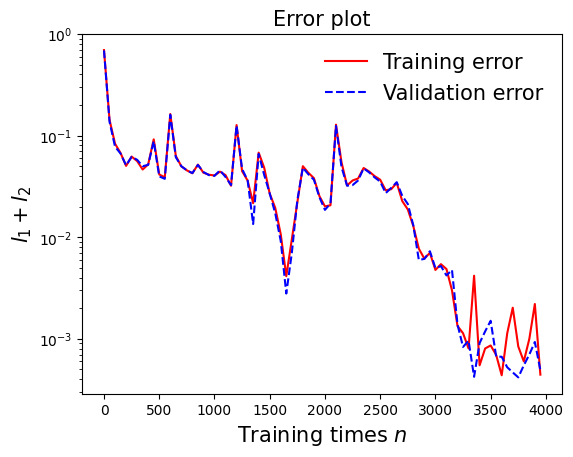

In [23]:
draw_loss(model)

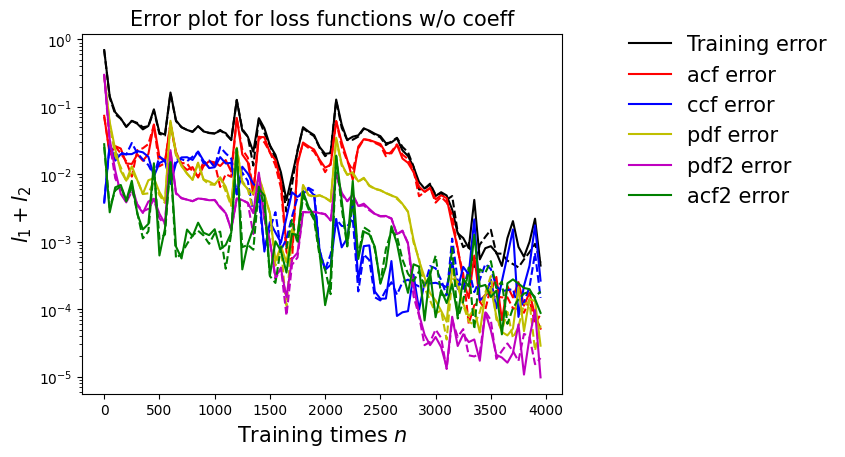

In [24]:
draw_errors(model)

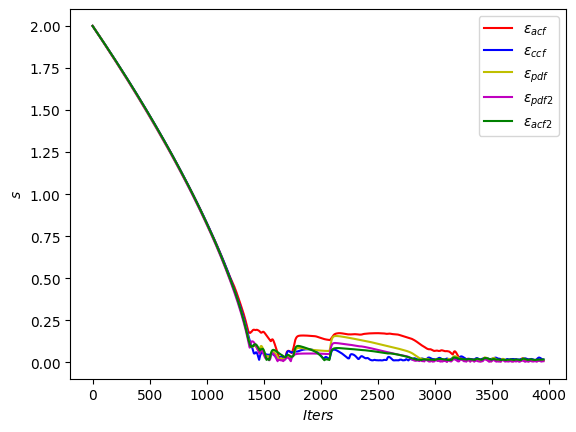

In [25]:
draw_adaptive_w(model)

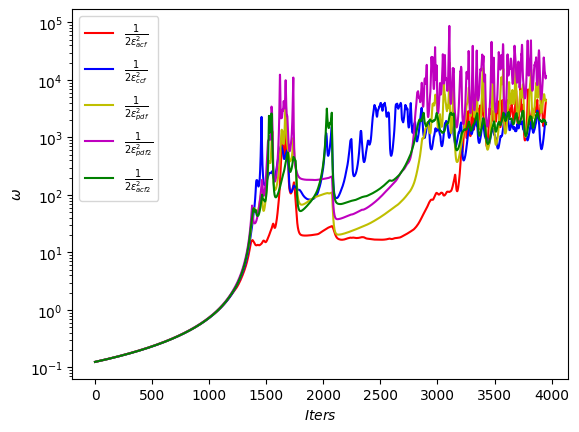

In [26]:
draw_epoch_w(model)

## Test 1: plot the sample path generated by SINN and the exact sample path 

In [27]:
def test1(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    # Test 1: plot the sample path generated by SINN and the exact sample path 
    skip = 0

    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$ and $q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$ and $q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF

In [28]:
def test2(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    
    # Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF  
    acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
    acf_t=StatLoss.acf(target)
    corr_p1=acf_p.detach().cpu().numpy()
    corr_t1=acf_t.detach().cpu().numpy()
    ccf_p=StatLoss.ccf(Pred[-sec_length:,:,:])
    ccf_t=StatLoss.ccf(target)
    corr_p2=ccf_p.detach().cpu().numpy()
    corr_t2=ccf_t.detach().cpu().numpy()
    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $\tilde{q}_1$',fontsize=15)    
    plt.plot(T, corr_t1[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $\tilde{q}_2$',fontsize=15)          
    plt.plot(T, corr_t1[...,-1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,-1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized CCF',fontsize=15)    
    plt.plot(T, corr_t2[:,:],'r')        # correlation function of the target 
    plt.plot(T, corr_p2[:,:], 'b--')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.ylim(-0.05,0.05)

## Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  

In [29]:
def test3(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    
    # Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
    rho_data =  StatLoss.gauss_kde(target, -5, 5, 400, None).cpu()
    rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 400, None).cpu()
    rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
    
    rho_data2 =  StatLoss.gauss_kde6(target, -5, 5, 400, None).cpu()
    rho_prediction2 = StatLoss.gauss_kde6(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()


    x=np.linspace(-5, 5, 400)
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function",fontsize=15)    
    plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of $q_{25}$')    # target PDF
    plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of $q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output $q_{25}$')  # PDF after the training 
    plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output $q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,0],label=r'Exact PDF of $q_{25}+q_{75}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,1],label=r'Exact PDF of $q_{25}-q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,0], ':',label=r'PDF of the output $q_{25}+q_{75}$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,1], ':',label=r'PDF of the output $q_{25}-q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,2],label=r'Exact PDF of $q_{25}+2q_{75}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,3],label=r'Exact PDF of $q_{25}-2q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,2], ':',label=r'PDF of the output $q_{25}+2q_{75}$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,3], ':',label=r'PDF of the output $q_{25}-2q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    fig = plt.figure(3)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,4],label=r'Exact PDF of $2q_{25}+q_{75}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,5],label=r'Exact PDF of $2q_{25}-q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,4], ':',label=r'PDF of the output $2q_{25}+q_{75}$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,5], ':',label=r'PDF of the output $2q_{25}-q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 4: Comparing the higher-order ACF

In [30]:
def test4(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    # Test 4: Comparing the higher-order ACF
    acf2=StatLoss.acf(target**2)
    pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
    acf2_app=StatLoss.acf(pred_norm**2)

    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_{25}^2$',fontsize=15)    
    plt.plot(T, acf2.detach().cpu().numpy()[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_{75}^2$',fontsize=15)          
    plt.plot(T, acf2.detach().cpu().numpy()[...,1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()    

## Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 

In [31]:
def test5(model):
    # Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 
    [a,b,c]=input.size()
    skip=20
    scale=10
    burnin=3
    fold=800
    batch_new=50
    ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred_L, _= model.predict_U(ran_input)
    prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new,2)
    ccf_p=StatLoss.ccf(Pred_L,method='bruteforce')

    LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
    LT=LT[0:-1]


    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

## Test 6: comparing scatter plots

In [32]:
def test6(model):
    # Test 6: scatter plot of SINN
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.scatter(Traj[:,:,0], Traj[:,:,1])
    plt.xlabel(r'$q_{25}(t)$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.scatter(prediction[:,:,0],prediction[:,:,1])
    plt.xlabel(r'$q_{25}(t)$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 7: comparing joint PDF contours

In [33]:
def test7(model):
    # Test 5: scatter plot of SINN
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    rho_data =  StatLoss.gauss_kde2D(target, -5, 5, 400, None).cpu()
    rho_prediction = StatLoss.gauss_kde2D(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
    
    fig = plt.figure(0, figsize=(5, 5))
    plt.title("PDF Contours",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

    xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
    axs[0]  = fig.gca()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    plt.contour(xx,yy,rho_data.numpy(),colors='r')
    plt.contour(xx,yy,rho_prediction.numpy(),colors='b',linestyles='dashed')

    plt.xlabel(r'$q_{25}$')
    plt.ylabel(r'$q_{75}$')

    
    
    fig = plt.figure(1,figsize=(5, 5))
    plt.title("MD trajectories",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

#     xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
    ax  = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cfset = ax.contourf(xx, yy, rho_data.numpy(), cmap='Blues')
    cset = ax.contour(xx, yy, rho_data.numpy(), colors='k')

    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel(r'$q_{25}$')
    ax.set_ylabel(r'$q_{75}$')

    
    
    fig = plt.figure(2,figsize=(5, 5))
    plt.title("SINN output",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

#     xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
    ax  = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cfset = ax.contourf(xx, yy, rho_prediction.numpy(), cmap='Blues')
    cset = ax.contour(xx, yy, rho_prediction.numpy(), colors='k')

    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel(r'$q_{25}$')
    ax.set_ylabel(r'$q_{75}$')

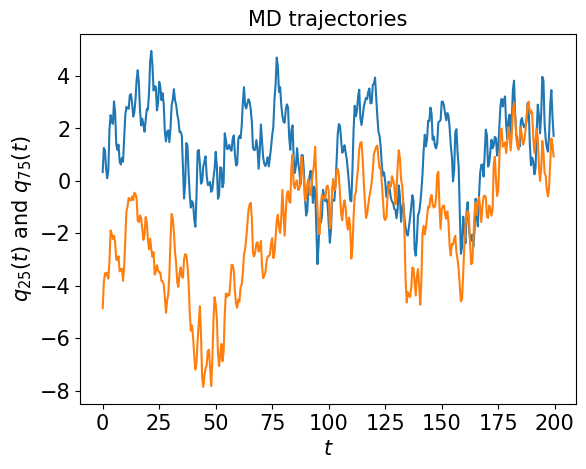

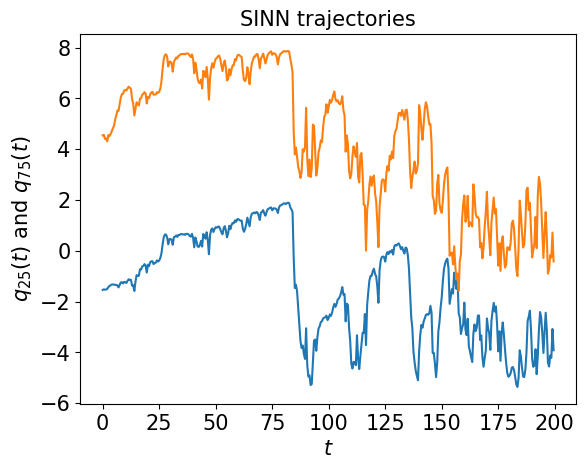

In [34]:
test1(model)

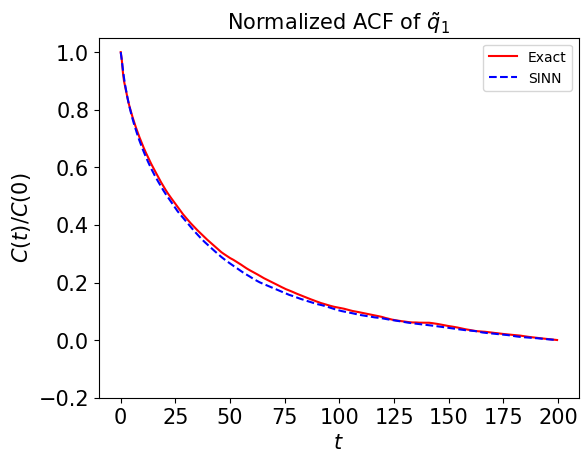

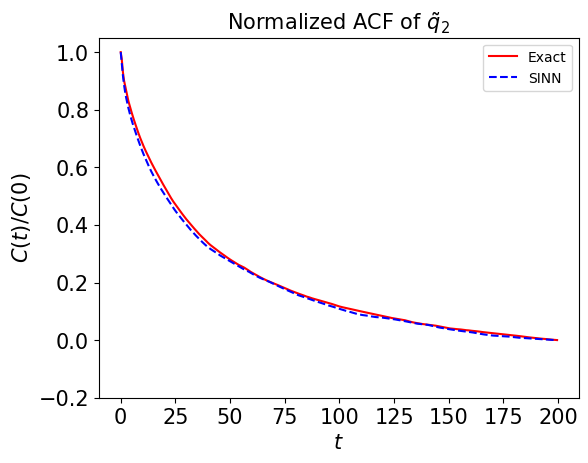

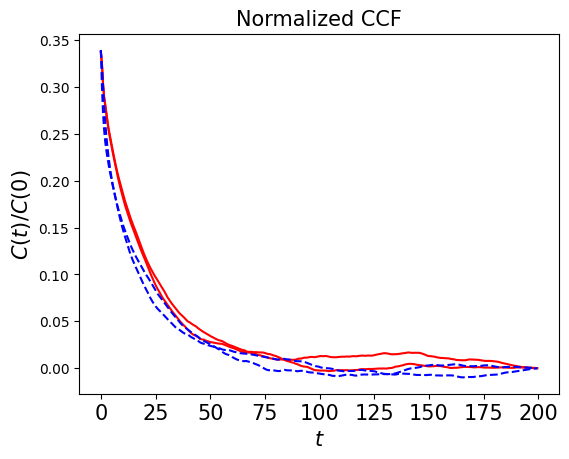

In [35]:
test2(model)

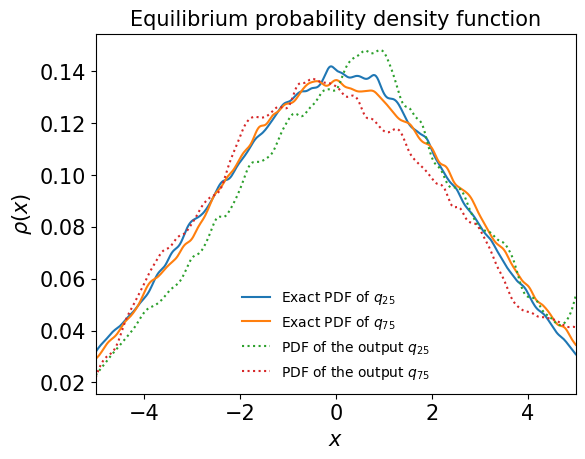

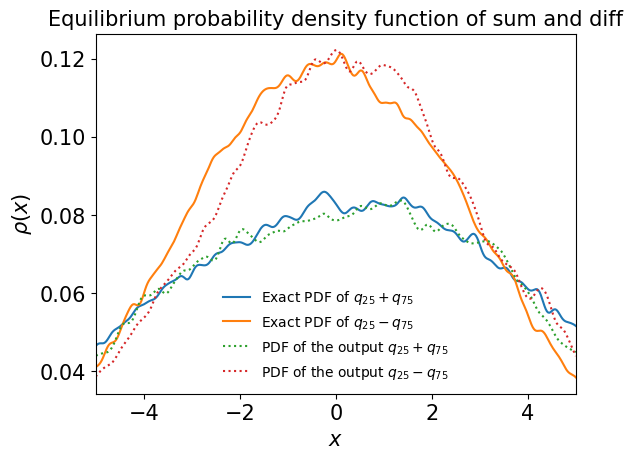

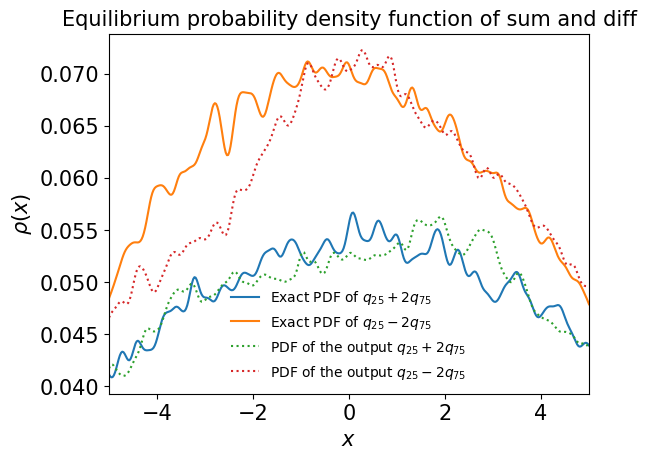

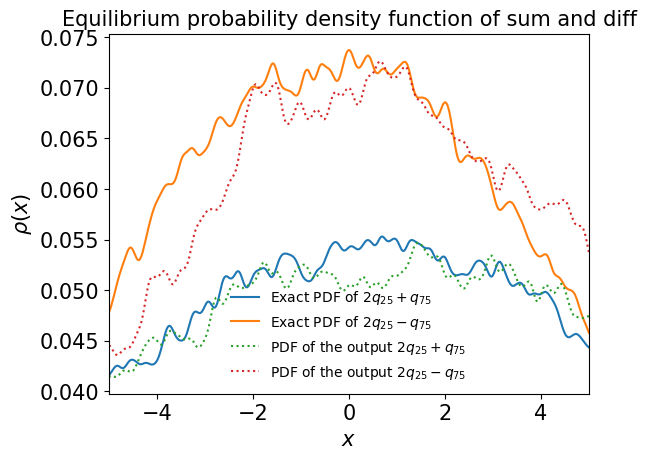

In [36]:
test3(model)

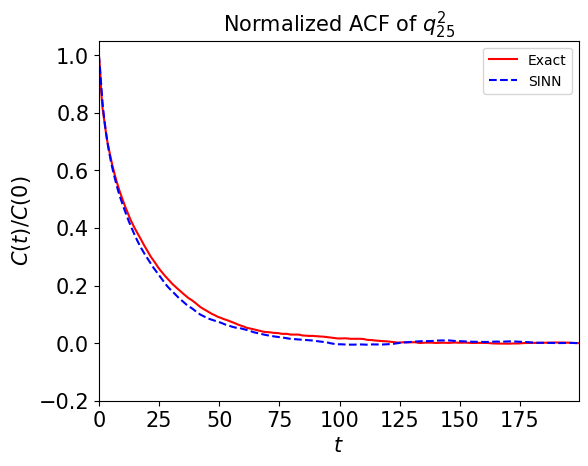

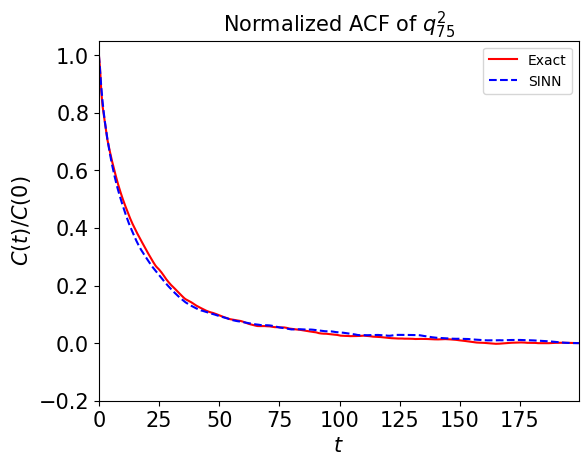

In [37]:
test4(model)

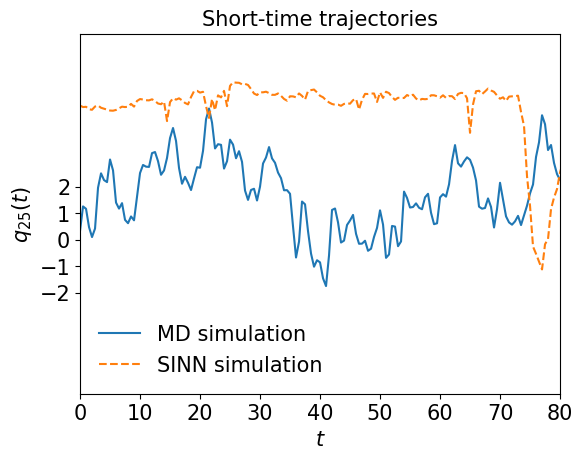

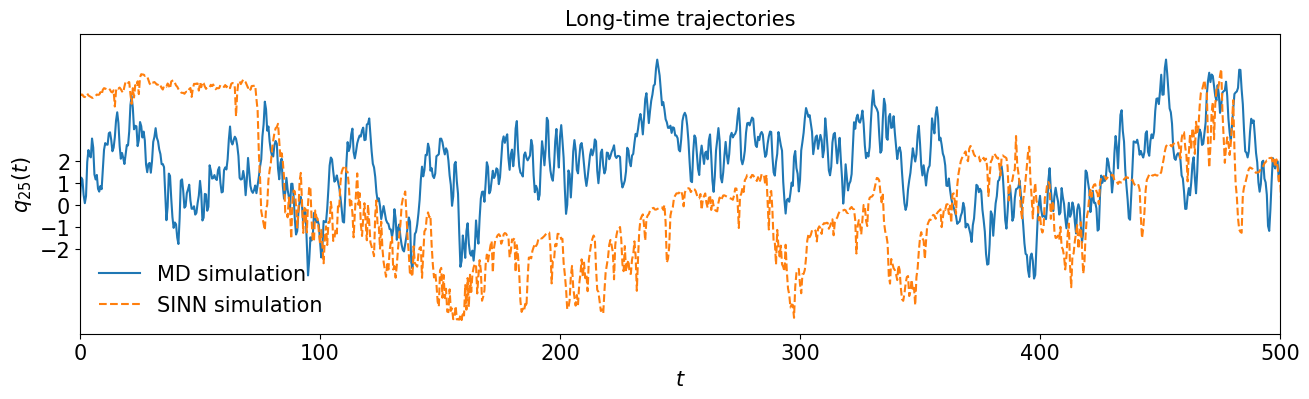

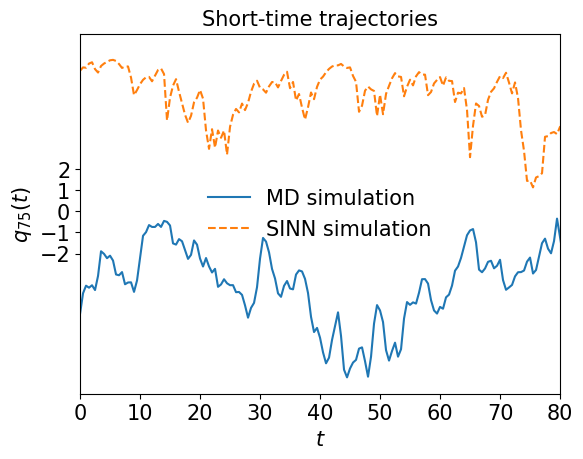

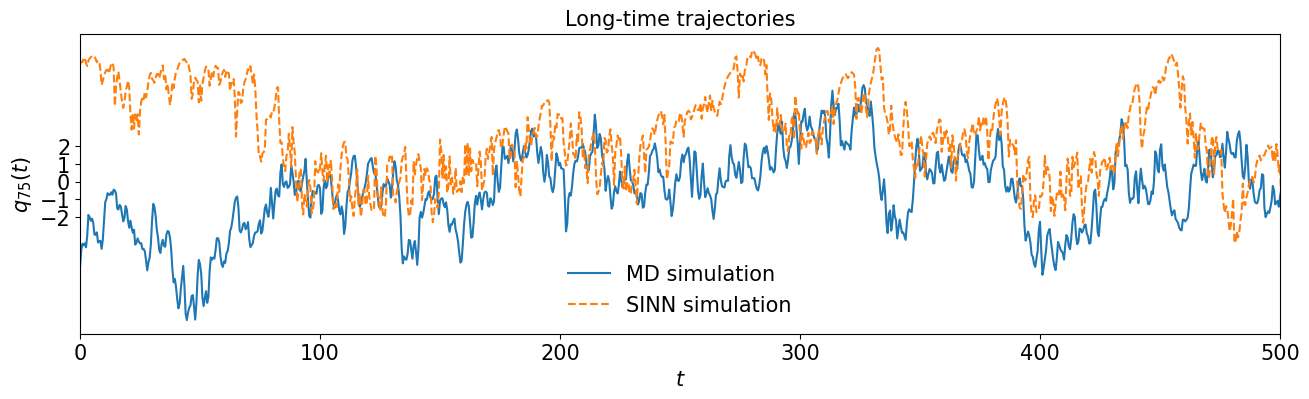

In [38]:
test5(model)

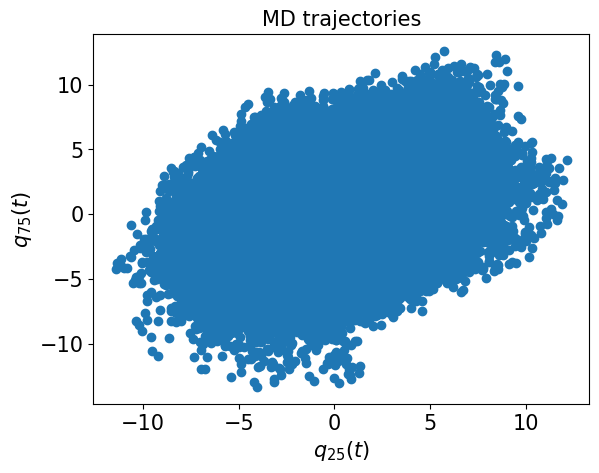

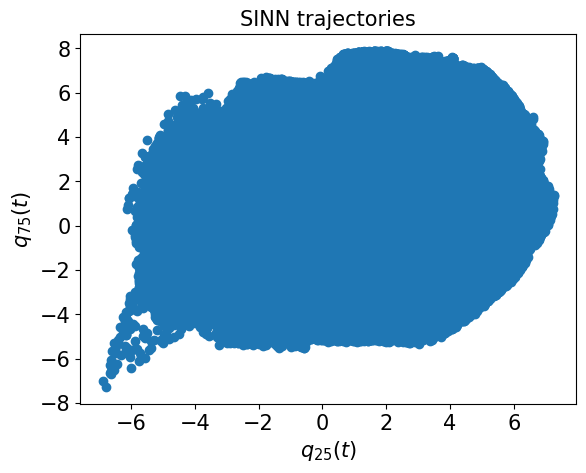

In [39]:
test6(model)

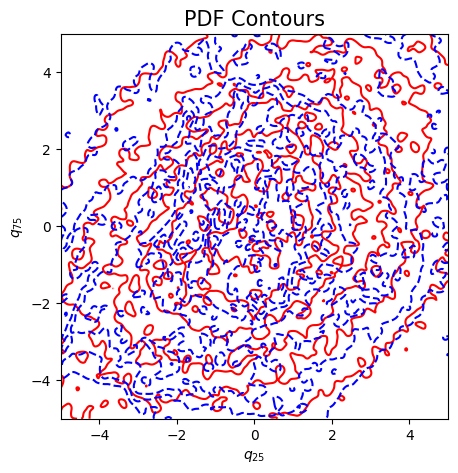

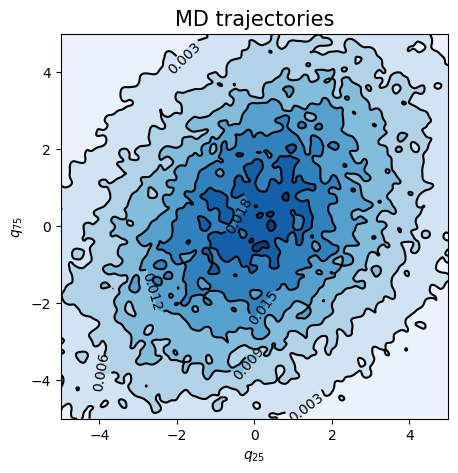

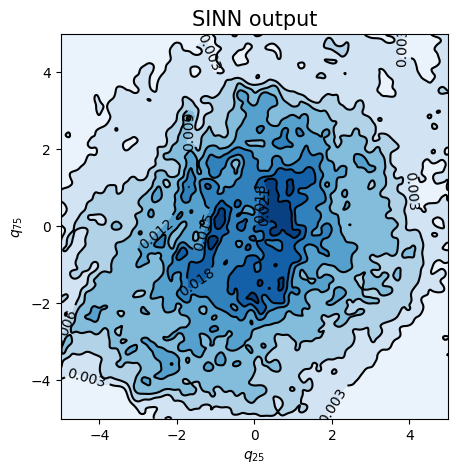

In [40]:
test7(model)

In [41]:
### Defining SINN model
net1 = SINN(2, 50, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model1 = Model(net=net1)
model1.train()

[0]-th step loss: 0.6982, 0.6925, acf: 0.07176, ccf: 0.00524, pdf: 0.29113, pdf2: 0.29838, acf2: 0.02600
[50]-th step loss: 0.1153, 0.1166, acf: 0.04479, ccf: 0.01462, pdf: 0.02100, pdf2: 0.02557, acf2: 0.01060
[100]-th step loss: 0.0676, 0.0628, acf: 0.02933, ccf: 0.01367, pdf: 0.00667, pdf2: 0.00737, acf2: 0.00574
[150]-th step loss: 0.0424, 0.0417, acf: 0.01617, ccf: 0.01465, pdf: 0.00438, pdf2: 0.00390, acf2: 0.00256
[200]-th step loss: 0.0286, 0.0273, acf: 0.00913, ccf: 0.00118, pdf: 0.00725, pdf2: 0.00291, acf2: 0.00679
[250]-th step loss: 0.0156, 0.0143, acf: 0.00436, ccf: 0.00238, pdf: 0.00326, pdf2: 0.00159, acf2: 0.00272
[300]-th step loss: 0.0442, 0.0428, acf: 0.01729, ccf: 0.00899, pdf: 0.01172, pdf2: 0.00261, acf2: 0.00215
[350]-th step loss: 0.0171, 0.0154, acf: 0.00698, ccf: 0.00245, pdf: 0.00194, pdf2: 0.00104, acf2: 0.00296
[400]-th step loss: 0.0617, 0.0624, acf: 0.01040, ccf: 0.01885, pdf: 0.02590, pdf2: 0.00405, acf2: 0.00322
[450]-th step loss: 0.0425, 0.0305, acf:

[3850]-th step loss: 0.0153, 0.0142, acf: 0.00020, ccf: 0.00017, pdf: 0.00506, pdf2: 0.00226, acf2: 0.00648
[3900]-th step loss: 0.0157, 0.0136, acf: 0.00376, ccf: 0.00078, pdf: 0.00540, pdf2: 0.00238, acf2: 0.00123
[3950]-th step loss: 0.0123, 0.0120, acf: 0.00153, ccf: 0.00020, pdf: 0.00518, pdf2: 0.00217, acf2: 0.00291
[4000]-th step loss: 0.0118, 0.0119, acf: 0.00267, ccf: 0.00030, pdf: 0.00510, pdf2: 0.00218, acf2: 0.00162
[4050]-th step loss: 0.0123, 0.0124, acf: 0.00449, ccf: 0.00007, pdf: 0.00508, pdf2: 0.00225, acf2: 0.00054
[4100]-th step loss: 0.0156, 0.0141, acf: 0.00633, ccf: 0.00010, pdf: 0.00509, pdf2: 0.00227, acf2: 0.00027
[4150]-th step loss: 0.0173, 0.0147, acf: 0.00683, ccf: 0.00032, pdf: 0.00510, pdf2: 0.00220, acf2: 0.00026
[4200]-th step loss: 0.0138, 0.0135, acf: 0.00571, ccf: 0.00018, pdf: 0.00524, pdf2: 0.00207, acf2: 0.00033
[4250]-th step loss: 0.0160, 0.0148, acf: 0.00711, ccf: 0.00017, pdf: 0.00523, pdf2: 0.00209, acf2: 0.00017
[4300]-th step loss: 0.0171,

[7650]-th step loss: 0.0151, 0.0145, acf: 0.00697, ccf: 0.00024, pdf: 0.00536, pdf2: 0.00190, acf2: 0.00005
[7700]-th step loss: 0.0143, 0.0151, acf: 0.00749, ccf: 0.00010, pdf: 0.00533, pdf2: 0.00189, acf2: 0.00032
[7750]-th step loss: 0.0152, 0.0152, acf: 0.00769, ccf: 0.00014, pdf: 0.00519, pdf2: 0.00200, acf2: 0.00015
[7800]-th step loss: 0.0133, 0.0158, acf: 0.00832, ccf: 0.00005, pdf: 0.00534, pdf2: 0.00192, acf2: 0.00015
[7850]-th step loss: 0.0152, 0.0147, acf: 0.00730, ccf: 0.00007, pdf: 0.00528, pdf2: 0.00197, acf2: 0.00006
[7900]-th step loss: 0.0128, 0.0143, acf: 0.00691, ccf: 0.00008, pdf: 0.00533, pdf2: 0.00196, acf2: 0.00006
[7950]-th step loss: 0.0138, 0.0143, acf: 0.00656, ccf: 0.00029, pdf: 0.00519, pdf2: 0.00199, acf2: 0.00027
[8000]-th step loss: 0.0140, 0.0153, acf: 0.00791, ccf: 0.00021, pdf: 0.00503, pdf2: 0.00210, acf2: 0.00009
[8050]-th step loss: 0.0141, 0.0132, acf: 0.00556, ccf: 0.00015, pdf: 0.00525, pdf2: 0.00205, acf2: 0.00016
[8100]-th step loss: 0.0133,

[11450]-th step loss: 0.0129, 0.0133, acf: 0.00549, ccf: 0.00010, pdf: 0.00553, pdf2: 0.00218, acf2: 0.00003
[11500]-th step loss: 0.0107, 0.0132, acf: 0.00545, ccf: 0.00016, pdf: 0.00525, pdf2: 0.00222, acf2: 0.00014
[11550]-th step loss: 0.0142, 0.0167, acf: 0.00845, ccf: 0.00013, pdf: 0.00566, pdf2: 0.00222, acf2: 0.00028
[11600]-th step loss: 0.0134, 0.0142, acf: 0.00645, ccf: 0.00009, pdf: 0.00541, pdf2: 0.00212, acf2: 0.00017
[11650]-th step loss: 0.0134, 0.0149, acf: 0.00698, ccf: 0.00010, pdf: 0.00557, pdf2: 0.00213, acf2: 0.00014
[11700]-th step loss: 0.0122, 0.0141, acf: 0.00629, ccf: 0.00010, pdf: 0.00550, pdf2: 0.00212, acf2: 0.00010
[11750]-th step loss: 0.0115, 0.0129, acf: 0.00496, ccf: 0.00023, pdf: 0.00541, pdf2: 0.00220, acf2: 0.00009
[11800]-th step loss: 0.0117, 0.0132, acf: 0.00520, ccf: 0.00020, pdf: 0.00547, pdf2: 0.00219, acf2: 0.00018
[11850]-th step loss: 0.0118, 0.0135, acf: 0.00560, ccf: 0.00011, pdf: 0.00543, pdf2: 0.00224, acf2: 0.00010
[11900]-th step los

[15250]-th step loss: 0.0013, 0.0020, acf: 0.00151, ccf: 0.00031, pdf: 0.00003, pdf2: 0.00002, acf2: 0.00013
[15300]-th step loss: 0.0011, 0.0018, acf: 0.00060, ccf: 0.00101, pdf: 0.00005, pdf2: 0.00004, acf2: 0.00015
[15350]-th step loss: 0.0005, 0.0014, acf: 0.00045, ccf: 0.00063, pdf: 0.00006, pdf2: 0.00002, acf2: 0.00021
[15400]-th step loss: 0.0007, 0.0008, acf: 0.00043, ccf: 0.00014, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00015
[15450]-th step loss: 0.0016, 0.0008, acf: 0.00048, ccf: 0.00023, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00008
[15500]-th step loss: 0.0007, 0.0011, acf: 0.00032, ccf: 0.00057, pdf: 0.00003, pdf2: 0.00003, acf2: 0.00014
[15550]-th step loss: 0.0010, 0.0007, acf: 0.00035, ccf: 0.00024, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00007
[15600]-th step loss: 0.0008, 0.0009, acf: 0.00037, ccf: 0.00036, pdf: 0.00007, pdf2: 0.00003, acf2: 0.00006
[15650]-th step loss: 0.0005, 0.0011, acf: 0.00041, ccf: 0.00061, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00007
[15700]-th step los

In [42]:
### Defining SINN model
net2 = SINN(2, 50, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model2 = Model(net=net2)
model2.train()

[0]-th step loss: 0.6977, 0.6923, acf: 0.07261, ccf: 0.00357, pdf: 0.29106, pdf2: 0.29826, acf2: 0.02684
[50]-th step loss: 0.1364, 0.1312, acf: 0.03433, ccf: 0.01768, pdf: 0.04068, pdf2: 0.03060, acf2: 0.00793
[100]-th step loss: 0.0675, 0.0688, acf: 0.00900, ccf: 0.02870, pdf: 0.01752, pdf2: 0.00922, acf2: 0.00437
[150]-th step loss: 0.0705, 0.0697, acf: 0.02522, ccf: 0.01557, pdf: 0.01055, pdf2: 0.01048, acf2: 0.00788
[200]-th step loss: 0.0454, 0.0442, acf: 0.01174, ccf: 0.01910, pdf: 0.00656, pdf2: 0.00462, acf2: 0.00222
[250]-th step loss: 0.0401, 0.0380, acf: 0.01049, ccf: 0.00331, pdf: 0.01608, pdf2: 0.00687, acf2: 0.00127
[300]-th step loss: 0.1450, 0.1441, acf: 0.05201, ccf: 0.04553, pdf: 0.02471, pdf2: 0.00844, acf2: 0.01344
[350]-th step loss: 0.0276, 0.0246, acf: 0.00272, ccf: 0.00322, pdf: 0.01115, pdf2: 0.00446, acf2: 0.00309
[400]-th step loss: 0.0208, 0.0200, acf: 0.00201, ccf: 0.00168, pdf: 0.00872, pdf2: 0.00441, acf2: 0.00316
[450]-th step loss: 0.0201, 0.0203, acf:

[3850]-th step loss: 0.0165, 0.0154, acf: 0.00077, ccf: 0.00130, pdf: 0.00624, pdf2: 0.00170, acf2: 0.00541
[3900]-th step loss: 0.0147, 0.0179, acf: 0.00019, ccf: 0.00131, pdf: 0.00609, pdf2: 0.00166, acf2: 0.00868
[3950]-th step loss: 0.0149, 0.0174, acf: 0.00010, ccf: 0.00241, pdf: 0.00601, pdf2: 0.00171, acf2: 0.00718
[4000]-th step loss: 0.0218, 0.0203, acf: 0.00117, ccf: 0.00058, pdf: 0.00730, pdf2: 0.00457, acf2: 0.00665
[4050]-th step loss: 0.0193, 0.0190, acf: 0.00034, ccf: 0.00257, pdf: 0.00604, pdf2: 0.00185, acf2: 0.00822
[4100]-th step loss: 0.0170, 0.0154, acf: 0.00068, ccf: 0.00058, pdf: 0.00619, pdf2: 0.00171, acf2: 0.00626
[4150]-th step loss: 0.0141, 0.0148, acf: 0.00062, ccf: 0.00036, pdf: 0.00557, pdf2: 0.00186, acf2: 0.00638
[4200]-th step loss: 0.0178, 0.0158, acf: 0.00030, ccf: 0.00087, pdf: 0.00564, pdf2: 0.00170, acf2: 0.00725
[4250]-th step loss: 0.0126, 0.0147, acf: 0.00050, ccf: 0.00057, pdf: 0.00545, pdf2: 0.00186, acf2: 0.00630
[4300]-th step loss: 0.0171,

[7650]-th step loss: 0.0321, 0.0293, acf: 0.01490, ccf: 0.00011, pdf: 0.00948, pdf2: 0.00454, acf2: 0.00028
[7700]-th step loss: 0.0293, 0.0305, acf: 0.01618, ccf: 0.00014, pdf: 0.00960, pdf2: 0.00441, acf2: 0.00015
[7750]-th step loss: 0.0312, 0.0290, acf: 0.01478, ccf: 0.00009, pdf: 0.00952, pdf2: 0.00440, acf2: 0.00025
[7800]-th step loss: 0.0318, 0.0294, acf: 0.01522, ccf: 0.00009, pdf: 0.00958, pdf2: 0.00430, acf2: 0.00020
[7850]-th step loss: 0.0334, 0.0301, acf: 0.01577, ccf: 0.00009, pdf: 0.00969, pdf2: 0.00426, acf2: 0.00029
[7900]-th step loss: 0.0316, 0.0286, acf: 0.01423, ccf: 0.00014, pdf: 0.00946, pdf2: 0.00445, acf2: 0.00027
[7950]-th step loss: 0.0297, 0.0283, acf: 0.01412, ccf: 0.00011, pdf: 0.00952, pdf2: 0.00420, acf2: 0.00033
[8000]-th step loss: 0.0311, 0.0286, acf: 0.01452, ccf: 0.00017, pdf: 0.00951, pdf2: 0.00417, acf2: 0.00025
[8050]-th step loss: 0.0305, 0.0285, acf: 0.01445, ccf: 0.00008, pdf: 0.00960, pdf2: 0.00408, acf2: 0.00029
[8100]-th step loss: 0.0307,

[11450]-th step loss: 0.0114, 0.0109, acf: 0.00555, ccf: 0.00010, pdf: 0.00336, pdf2: 0.00172, acf2: 0.00017
[11500]-th step loss: 0.0069, 0.0055, acf: 0.00302, ccf: 0.00010, pdf: 0.00145, pdf2: 0.00058, acf2: 0.00032
[11550]-th step loss: 0.0009, 0.0010, acf: 0.00022, ccf: 0.00021, pdf: 0.00031, pdf2: 0.00009, acf2: 0.00020
[11600]-th step loss: 0.0022, 0.0018, acf: 0.00022, ccf: 0.00015, pdf: 0.00056, pdf2: 0.00009, acf2: 0.00076
[11650]-th step loss: 0.0145, 0.0132, acf: 0.00503, ccf: 0.00037, pdf: 0.00493, pdf2: 0.00271, acf2: 0.00019
[11700]-th step loss: 0.0132, 0.0114, acf: 0.00420, ccf: 0.00092, pdf: 0.00371, pdf2: 0.00240, acf2: 0.00022
[11750]-th step loss: 0.0133, 0.0099, acf: 0.00492, ccf: 0.00005, pdf: 0.00304, pdf2: 0.00179, acf2: 0.00007
[11800]-th step loss: 0.0072, 0.0075, acf: 0.00467, ccf: 0.00038, pdf: 0.00129, pdf2: 0.00106, acf2: 0.00006
[11850]-th step loss: 0.0045, 0.0040, acf: 0.00201, ccf: 0.00066, pdf: 0.00079, pdf2: 0.00039, acf2: 0.00010
[11900]-th step los

In [43]:
### Defining SINN model
net3 = SINN(2, 50, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model3 = Model(net=net3)
model3.train()

[0]-th step loss: 0.6938, 0.6926, acf: 0.07182, ccf: 0.00526, pdf: 0.29112, pdf2: 0.29825, acf2: 0.02616
[50]-th step loss: 0.1239, 0.1158, acf: 0.03513, ccf: 0.01632, pdf: 0.03423, pdf2: 0.02263, acf2: 0.00749
[100]-th step loss: 0.0701, 0.0694, acf: 0.01805, ccf: 0.01939, pdf: 0.01673, pdf2: 0.01072, acf2: 0.00452
[150]-th step loss: 0.0315, 0.0426, acf: 0.00470, ccf: 0.00775, pdf: 0.01991, pdf2: 0.00854, acf2: 0.00171
[200]-th step loss: 0.0453, 0.0450, acf: 0.01240, ccf: 0.00814, pdf: 0.01010, pdf2: 0.01142, acf2: 0.00293
[250]-th step loss: 0.0209, 0.0201, acf: 0.00925, ccf: 0.00133, pdf: 0.00507, pdf2: 0.00257, acf2: 0.00193
[300]-th step loss: 0.0201, 0.0183, acf: 0.00479, ccf: 0.00157, pdf: 0.00440, pdf2: 0.00308, acf2: 0.00442
[350]-th step loss: 0.0174, 0.0169, acf: 0.00761, ccf: 0.00135, pdf: 0.00363, pdf2: 0.00241, acf2: 0.00189
[400]-th step loss: 0.0142, 0.0128, acf: 0.00220, ccf: 0.00149, pdf: 0.00271, pdf2: 0.00140, acf2: 0.00500
[450]-th step loss: 0.0417, 0.0457, acf:

[3850]-th step loss: 0.0369, 0.0331, acf: 0.02418, ccf: 0.00767, pdf: 0.00011, pdf2: 0.00002, acf2: 0.00108
[3900]-th step loss: 0.0328, 0.0318, acf: 0.02907, ccf: 0.00243, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00025
[3950]-th step loss: 0.0620, 0.0646, acf: 0.03728, ccf: 0.00399, pdf: 0.00623, pdf2: 0.00212, acf2: 0.01495
[4000]-th step loss: 0.0559, 0.0566, acf: 0.04278, ccf: 0.00093, pdf: 0.00142, pdf2: 0.00076, acf2: 0.01068
[4050]-th step loss: 0.0449, 0.0418, acf: 0.03255, ccf: 0.00132, pdf: 0.00129, pdf2: 0.00077, acf2: 0.00588
[4100]-th step loss: 0.0449, 0.0442, acf: 0.03566, ccf: 0.00071, pdf: 0.00103, pdf2: 0.00063, acf2: 0.00617
[4150]-th step loss: 0.0453, 0.0436, acf: 0.03664, ccf: 0.00040, pdf: 0.00067, pdf2: 0.00049, acf2: 0.00542
[4200]-th step loss: 0.0500, 0.0462, acf: 0.03967, ccf: 0.00018, pdf: 0.00044, pdf2: 0.00040, acf2: 0.00556
[4250]-th step loss: 0.0419, 0.0411, acf: 0.03708, ccf: 0.00014, pdf: 0.00049, pdf2: 0.00042, acf2: 0.00297
[4300]-th step loss: 0.0422,

[7650]-th step loss: 0.1212, 0.1209, acf: 0.08178, ccf: 0.00735, pdf: 0.00005, pdf2: 0.00000, acf2: 0.03176
[7700]-th step loss: 0.1174, 0.1178, acf: 0.08027, ccf: 0.00728, pdf: 0.00003, pdf2: 0.00000, acf2: 0.03023
[7750]-th step loss: 0.1072, 0.1025, acf: 0.07219, ccf: 0.00706, pdf: 0.00002, pdf2: 0.00001, acf2: 0.02324
[7800]-th step loss: 0.1078, 0.1065, acf: 0.07538, ccf: 0.00678, pdf: 0.00001, pdf2: 0.00000, acf2: 0.02432
[7850]-th step loss: 0.1033, 0.1032, acf: 0.07419, ccf: 0.00662, pdf: 0.00001, pdf2: 0.00000, acf2: 0.02239
[7900]-th step loss: 0.0913, 0.0841, acf: 0.06123, ccf: 0.00584, pdf: 0.00001, pdf2: 0.00001, acf2: 0.01698
[7950]-th step loss: 0.0922, 0.0865, acf: 0.06370, ccf: 0.00542, pdf: 0.00000, pdf2: 0.00000, acf2: 0.01733
[8000]-th step loss: 0.0862, 0.0827, acf: 0.06111, ccf: 0.00433, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01722
[8050]-th step loss: 0.0879, 0.0861, acf: 0.06501, ccf: 0.00418, pdf: 0.00000, pdf2: 0.00000, acf2: 0.01695
[8100]-th step loss: 0.0865,

[11450]-th step loss: 0.0329, 0.0317, acf: 0.03024, ccf: 0.00118, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00025
[11500]-th step loss: 0.0312, 0.0307, acf: 0.02932, ccf: 0.00105, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00033
[11550]-th step loss: 0.0509, 0.0372, acf: 0.03640, ccf: 0.00058, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00018
[11600]-th step loss: 0.0324, 0.0316, acf: 0.02986, ccf: 0.00137, pdf: 0.00008, pdf2: 0.00002, acf2: 0.00027
[11650]-th step loss: 0.0404, 0.0366, acf: 0.03559, ccf: 0.00060, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00038
[11700]-th step loss: 0.0656, 0.0755, acf: 0.02987, ccf: 0.02469, pdf: 0.01164, pdf2: 0.00420, acf2: 0.00514
[11750]-th step loss: 0.0256, 0.0261, acf: 0.01203, ccf: 0.00389, pdf: 0.00610, pdf2: 0.00367, acf2: 0.00037
[11800]-th step loss: 0.0200, 0.0192, acf: 0.00316, ccf: 0.00371, pdf: 0.00604, pdf2: 0.00363, acf2: 0.00265
[11850]-th step loss: 0.0260, 0.0311, acf: 0.00077, ccf: 0.00967, pdf: 0.00619, pdf2: 0.00349, acf2: 0.01102
[11900]-th step los

[15250]-th step loss: 0.0158, 0.0153, acf: 0.00691, ccf: 0.00013, pdf: 0.00538, pdf2: 0.00260, acf2: 0.00033
[15300]-th step loss: 0.0165, 0.0161, acf: 0.00842, ccf: 0.00007, pdf: 0.00525, pdf2: 0.00223, acf2: 0.00012
[15350]-th step loss: 0.0210, 0.0211, acf: 0.01240, ccf: 0.00020, pdf: 0.00612, pdf2: 0.00219, acf2: 0.00016
[15400]-th step loss: 0.0149, 0.0151, acf: 0.00755, ccf: 0.00010, pdf: 0.00523, pdf2: 0.00219, acf2: 0.00008
[15450]-th step loss: 0.0161, 0.0157, acf: 0.00803, ccf: 0.00020, pdf: 0.00523, pdf2: 0.00217, acf2: 0.00010
[15500]-th step loss: 0.0175, 0.0178, acf: 0.00933, ccf: 0.00016, pdf: 0.00589, pdf2: 0.00214, acf2: 0.00026
[15550]-th step loss: 0.0160, 0.0188, acf: 0.01076, ccf: 0.00012, pdf: 0.00564, pdf2: 0.00208, acf2: 0.00020
[15600]-th step loss: 0.0152, 0.0156, acf: 0.00804, ccf: 0.00013, pdf: 0.00525, pdf2: 0.00214, acf2: 0.00008
[15650]-th step loss: 0.0165, 0.0164, acf: 0.00863, ccf: 0.00013, pdf: 0.00547, pdf2: 0.00208, acf2: 0.00010
[15700]-th step los

[19050]-th step loss: 0.0249, 0.0228, acf: 0.01366, ccf: 0.00031, pdf: 0.00652, pdf2: 0.00215, acf2: 0.00019
[19100]-th step loss: 0.0249, 0.0231, acf: 0.01432, ccf: 0.00015, pdf: 0.00629, pdf2: 0.00213, acf2: 0.00016
[19150]-th step loss: 0.0210, 0.0204, acf: 0.01198, ccf: 0.00013, pdf: 0.00611, pdf2: 0.00209, acf2: 0.00008
[19200]-th step loss: 0.0190, 0.0195, acf: 0.01118, ccf: 0.00024, pdf: 0.00599, pdf2: 0.00203, acf2: 0.00010
[19250]-th step loss: 0.0190, 0.0205, acf: 0.01228, ccf: 0.00026, pdf: 0.00605, pdf2: 0.00186, acf2: 0.00010
[19300]-th step loss: 0.0220, 0.0204, acf: 0.01216, ccf: 0.00010, pdf: 0.00614, pdf2: 0.00186, acf2: 0.00010
[19350]-th step loss: 0.0202, 0.0193, acf: 0.01116, ccf: 0.00026, pdf: 0.00593, pdf2: 0.00185, acf2: 0.00008
[19400]-th step loss: 0.0222, 0.0199, acf: 0.01187, ccf: 0.00020, pdf: 0.00585, pdf2: 0.00184, acf2: 0.00014
[19450]-th step loss: 0.0179, 0.0185, acf: 0.01058, ccf: 0.00014, pdf: 0.00582, pdf2: 0.00186, acf2: 0.00013
[19500]-th step los

In [44]:
### Defining SINN model
net4 = SINN(2, 50, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model4 = Model(net=net4)
model4.train()

[0]-th step loss: 0.6996, 0.6905, acf: 0.07105, ccf: 0.00426, pdf: 0.29122, pdf2: 0.29835, acf2: 0.02564
[50]-th step loss: 0.1420, 0.1320, acf: 0.02786, ccf: 0.02007, pdf: 0.04406, pdf2: 0.03615, acf2: 0.00388
[100]-th step loss: 0.0674, 0.0631, acf: 0.02078, ccf: 0.01931, pdf: 0.01408, pdf2: 0.00804, acf2: 0.00088
[150]-th step loss: 0.0551, 0.0507, acf: 0.01395, ccf: 0.02258, pdf: 0.00837, pdf2: 0.00501, acf2: 0.00079
[200]-th step loss: 0.0526, 0.0462, acf: 0.01466, ccf: 0.02038, pdf: 0.00655, pdf2: 0.00358, acf2: 0.00100
[250]-th step loss: 0.0623, 0.0581, acf: 0.03182, ccf: 0.01138, pdf: 0.00813, pdf2: 0.00436, acf2: 0.00244
[300]-th step loss: 0.0469, 0.0455, acf: 0.00967, ccf: 0.01889, pdf: 0.01182, pdf2: 0.00274, acf2: 0.00242
[350]-th step loss: 0.0320, 0.0288, acf: 0.00755, ccf: 0.00505, pdf: 0.01304, pdf2: 0.00211, acf2: 0.00101
[400]-th step loss: 0.0212, 0.0205, acf: 0.00824, ccf: 0.00253, pdf: 0.00748, pdf2: 0.00148, acf2: 0.00077
[450]-th step loss: 0.0780, 0.0711, acf:

[3850]-th step loss: 0.0123, 0.0107, acf: 0.01031, ccf: 0.00015, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00020
[3900]-th step loss: 0.0134, 0.0113, acf: 0.01096, ccf: 0.00007, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00020
[3950]-th step loss: 0.0148, 0.0113, acf: 0.01097, ccf: 0.00015, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00021
[4000]-th step loss: 0.0188, 0.0148, acf: 0.01421, ccf: 0.00014, pdf: 0.00013, pdf2: 0.00004, acf2: 0.00028
[4050]-th step loss: 0.0149, 0.0135, acf: 0.01276, ccf: 0.00012, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00058
[4100]-th step loss: 0.0143, 0.0113, acf: 0.01055, ccf: 0.00015, pdf: 0.00008, pdf2: 0.00001, acf2: 0.00051
[4150]-th step loss: 0.0115, 0.0093, acf: 0.00867, ccf: 0.00011, pdf: 0.00005, pdf2: 0.00002, acf2: 0.00044
[4200]-th step loss: 0.0104, 0.0089, acf: 0.00830, ccf: 0.00011, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00043
[4250]-th step loss: 0.0149, 0.0107, acf: 0.01017, ccf: 0.00019, pdf: 0.00004, pdf2: 0.00001, acf2: 0.00032
[4300]-th step loss: 0.0124,

[7650]-th step loss: 0.0088, 0.0076, acf: 0.00502, ccf: 0.00048, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00209
[7700]-th step loss: 0.0120, 0.0070, acf: 0.00569, ccf: 0.00062, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00071
[7750]-th step loss: 0.0099, 0.0083, acf: 0.00695, ccf: 0.00095, pdf: 0.00004, pdf2: 0.00001, acf2: 0.00036
[7800]-th step loss: 0.0090, 0.0062, acf: 0.00521, ccf: 0.00033, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00059
[7850]-th step loss: 0.0066, 0.0066, acf: 0.00562, ccf: 0.00031, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00064
[7900]-th step loss: 0.0037, 0.0044, acf: 0.00346, ccf: 0.00056, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00037
[7950]-th step loss: 0.0025, 0.0020, acf: 0.00137, ccf: 0.00044, pdf: 0.00003, pdf2: 0.00003, acf2: 0.00010
[8000]-th step loss: 0.0020, 0.0019, acf: 0.00123, ccf: 0.00058, pdf: 0.00003, pdf2: 0.00003, acf2: 0.00006
[8050]-th step loss: 0.0040, 0.0029, acf: 0.00208, ccf: 0.00053, pdf: 0.00007, pdf2: 0.00002, acf2: 0.00018
[8100]-th step loss: 0.0035,

[11450]-th step loss: 0.1277, 0.0986, acf: 0.07560, ccf: 0.00493, pdf: 0.00000, pdf2: 0.00000, acf2: 0.01803
[11500]-th step loss: 0.0720, 0.0554, acf: 0.04069, ccf: 0.00599, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00873
[11550]-th step loss: 0.0505, 0.0435, acf: 0.03762, ccf: 0.00126, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00461
[11600]-th step loss: 0.0453, 0.0509, acf: 0.03171, ccf: 0.00368, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01547
[11650]-th step loss: 0.0710, 0.0550, acf: 0.04976, ccf: 0.00156, pdf: 0.00000, pdf2: 0.00000, acf2: 0.00368
[11700]-th step loss: 0.0542, 0.0507, acf: 0.02439, ccf: 0.00638, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01996
[11750]-th step loss: 0.1278, 0.1111, acf: 0.08130, ccf: 0.00531, pdf: 0.00000, pdf2: 0.00000, acf2: 0.02444
[11800]-th step loss: 0.1089, 0.1106, acf: 0.06363, ccf: 0.00338, pdf: 0.00000, pdf2: 0.00000, acf2: 0.04356
[11850]-th step loss: 0.0895, 0.0698, acf: 0.04435, ccf: 0.00189, pdf: 0.00000, pdf2: 0.00001, acf2: 0.02359
[11900]-th step los

[15250]-th step loss: 0.1276, 0.1276, acf: 0.08774, ccf: 0.00527, pdf: 0.00001, pdf2: 0.00000, acf2: 0.03454
[15300]-th step loss: 0.1271, 0.1269, acf: 0.08719, ccf: 0.00521, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03453
[15350]-th step loss: 0.1270, 0.1267, acf: 0.08701, ccf: 0.00519, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03450
[15400]-th step loss: 0.1270, 0.1269, acf: 0.08717, ccf: 0.00523, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03446
[15450]-th step loss: 0.1271, 0.1271, acf: 0.08756, ccf: 0.00519, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03429
[15500]-th step loss: 0.1273, 0.1272, acf: 0.08779, ccf: 0.00518, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03426
[15550]-th step loss: 0.1270, 0.1269, acf: 0.08739, ccf: 0.00520, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03431
[15600]-th step loss: 0.1270, 0.1268, acf: 0.08736, ccf: 0.00520, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03428
[15650]-th step loss: 0.1269, 0.1266, acf: 0.08722, ccf: 0.00518, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03419
[15700]-th step los

[19050]-th step loss: 0.1197, 0.1197, acf: 0.08221, ccf: 0.00395, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03358
[19100]-th step loss: 0.1200, 0.1201, acf: 0.08252, ccf: 0.00398, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03360
[19150]-th step loss: 0.1204, 0.1203, acf: 0.08261, ccf: 0.00400, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03365
[19200]-th step loss: 0.1215, 0.1213, acf: 0.08326, ccf: 0.00404, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03400
[19250]-th step loss: 0.1188, 0.1190, acf: 0.08123, ccf: 0.00375, pdf: 0.00002, pdf2: 0.00001, acf2: 0.03398
[19300]-th step loss: 0.1093, 0.1094, acf: 0.07482, ccf: 0.00402, pdf: 0.00030, pdf2: 0.00014, acf2: 0.03014
[19350]-th step loss: 0.1065, 0.1011, acf: 0.06941, ccf: 0.00419, pdf: 0.00337, pdf2: 0.00099, acf2: 0.02314
[19400]-th step loss: 0.0795, 0.0830, acf: 0.06268, ccf: 0.00162, pdf: 0.00097, pdf2: 0.00052, acf2: 0.01719
[19450]-th step loss: 0.0626, 0.0609, acf: 0.04901, ccf: 0.00048, pdf: 0.00043, pdf2: 0.00026, acf2: 0.01077
[19500]-th step los

In [45]:
### Defining SINN model
net5 = SINN(2, 50, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model5 = Model(net=net5)
model5.train()

[0]-th step loss: 0.7218, 0.6986, acf: 0.07603, ccf: 0.00352, pdf: 0.29118, pdf2: 0.29838, acf2: 0.02953
[50]-th step loss: 0.1228, 0.1214, acf: 0.03863, ccf: 0.01702, pdf: 0.02841, pdf2: 0.03048, acf2: 0.00692
[100]-th step loss: 0.0636, 0.0664, acf: 0.01619, ccf: 0.03006, pdf: 0.00609, pdf2: 0.01123, acf2: 0.00287
[150]-th step loss: 0.0479, 0.0451, acf: 0.01610, ccf: 0.01891, pdf: 0.00240, pdf2: 0.00668, acf2: 0.00100
[200]-th step loss: 0.0969, 0.1427, acf: 0.04185, ccf: 0.01079, pdf: 0.05285, pdf2: 0.03140, acf2: 0.00583
[250]-th step loss: 0.0570, 0.0560, acf: 0.01834, ccf: 0.01743, pdf: 0.00745, pdf2: 0.01022, acf2: 0.00257
[300]-th step loss: 0.0432, 0.0433, acf: 0.02083, ccf: 0.01130, pdf: 0.00429, pdf2: 0.00494, acf2: 0.00192
[350]-th step loss: 0.0400, 0.0465, acf: 0.03235, ccf: 0.00646, pdf: 0.00342, pdf2: 0.00345, acf2: 0.00079
[400]-th step loss: 0.0443, 0.0433, acf: 0.02800, ccf: 0.00723, pdf: 0.00392, pdf2: 0.00343, acf2: 0.00075
[450]-th step loss: 0.0400, 0.0426, acf:

[3850]-th step loss: 0.0015, 0.0011, acf: 0.00060, ccf: 0.00025, pdf: 0.00005, pdf2: 0.00001, acf2: 0.00022
[3900]-th step loss: 0.0012, 0.0011, acf: 0.00027, ccf: 0.00034, pdf: 0.00008, pdf2: 0.00002, acf2: 0.00041
[3950]-th step loss: 0.0009, 0.0013, acf: 0.00039, ccf: 0.00064, pdf: 0.00004, pdf2: 0.00002, acf2: 0.00024
[4000]-th step loss: 0.0006, 0.0008, acf: 0.00011, ccf: 0.00035, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00025
[4050]-th step loss: 0.0016, 0.0008, acf: 0.00013, ccf: 0.00031, pdf: 0.00008, pdf2: 0.00003, acf2: 0.00026
[4100]-th step loss: 0.0007, 0.0007, acf: 0.00004, ccf: 0.00044, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00023
[4150]-th step loss: 0.0004, 0.0016, acf: 0.00009, ccf: 0.00129, pdf: 0.00002, pdf2: 0.00002, acf2: 0.00018
[4200]-th step loss: 0.0010, 0.0013, acf: 0.00014, ccf: 0.00072, pdf: 0.00017, pdf2: 0.00004, acf2: 0.00023
[4250]-th step loss: 0.0007, 0.0006, acf: 0.00005, ccf: 0.00025, pdf: 0.00003, pdf2: 0.00002, acf2: 0.00023
[4300]-th step loss: 0.0007,

In [46]:
### Defining SINN model
net6 = SINN(2, 50, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model6 = Model(net=net6)
model6.train()

[0]-th step loss: 0.7040, 0.6924, acf: 0.07225, ccf: 0.00406, pdf: 0.29124, pdf2: 0.29838, acf2: 0.02652
[50]-th step loss: 0.0570, 0.0540, acf: 0.01803, ccf: 0.00243, pdf: 0.01818, pdf2: 0.01297, acf2: 0.00238
[100]-th step loss: 0.0554, 0.0532, acf: 0.02138, ccf: 0.00581, pdf: 0.00999, pdf2: 0.00760, acf2: 0.00841
[150]-th step loss: 0.0347, 0.0278, acf: 0.00505, ccf: 0.00549, pdf: 0.01034, pdf2: 0.00503, acf2: 0.00187
[200]-th step loss: 0.0521, 0.0504, acf: 0.01864, ccf: 0.01280, pdf: 0.00532, pdf2: 0.00727, acf2: 0.00639
[250]-th step loss: 0.0689, 0.0574, acf: 0.00281, ccf: 0.00913, pdf: 0.02698, pdf2: 0.00925, acf2: 0.00919
[300]-th step loss: 0.0379, 0.0449, acf: 0.00890, ccf: 0.00566, pdf: 0.01572, pdf2: 0.00878, acf2: 0.00585
[350]-th step loss: 0.0244, 0.0205, acf: 0.00319, ccf: 0.00458, pdf: 0.00603, pdf2: 0.00217, acf2: 0.00453
[400]-th step loss: 0.0151, 0.0145, acf: 0.00643, ccf: 0.00069, pdf: 0.00319, pdf2: 0.00198, acf2: 0.00220
[450]-th step loss: 0.0090, 0.0089, acf:

[3850]-th step loss: 0.0005, 0.0004, acf: 0.00003, ccf: 0.00023, pdf: 0.00003, pdf2: 0.00003, acf2: 0.00010
Training finished
Training time: 319.70
Training time per iteration: 0.08
Number of Iterations:3851


In [47]:
### Defining SINN model
net7 = SINN(2, 50, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model7 = Model(net=net7)
model7.train()

[0]-th step loss: 0.6946, 0.6899, acf: 0.07076, ccf: 0.00434, pdf: 0.29106, pdf2: 0.29836, acf2: 0.02536
[50]-th step loss: 0.1135, 0.1090, acf: 0.03054, ccf: 0.01895, pdf: 0.02561, pdf2: 0.02853, acf2: 0.00534
[100]-th step loss: 0.0770, 0.0710, acf: 0.01374, ccf: 0.02725, pdf: 0.01171, pdf2: 0.01580, acf2: 0.00252
[150]-th step loss: 0.0667, 0.0600, acf: 0.01613, ccf: 0.02169, pdf: 0.01121, pdf2: 0.00881, acf2: 0.00216
[200]-th step loss: 0.0211, 0.0240, acf: 0.00479, ccf: 0.00322, pdf: 0.00750, pdf2: 0.00358, acf2: 0.00493
[250]-th step loss: 0.0163, 0.0166, acf: 0.00610, ccf: 0.00088, pdf: 0.00502, pdf2: 0.00240, acf2: 0.00216
[300]-th step loss: 0.0611, 0.0600, acf: 0.01250, ccf: 0.02098, pdf: 0.01224, pdf2: 0.01329, acf2: 0.00094
[350]-th step loss: 0.0452, 0.0451, acf: 0.01351, ccf: 0.01867, pdf: 0.00534, pdf2: 0.00627, acf2: 0.00131
[400]-th step loss: 0.0393, 0.0391, acf: 0.01161, ccf: 0.01814, pdf: 0.00383, pdf2: 0.00359, acf2: 0.00189
[450]-th step loss: 0.0204, 0.0196, acf:

In [48]:
### Defining SINN model
net8 = SINN(2, 50, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model8 = Model(net=net8)
model8.train()

[0]-th step loss: 0.6971, 0.6877, acf: 0.06996, ccf: 0.00360, pdf: 0.29113, pdf2: 0.29831, acf2: 0.02465
[50]-th step loss: 0.1182, 0.0945, acf: 0.01569, ccf: 0.01886, pdf: 0.03429, pdf2: 0.02256, acf2: 0.00308
[100]-th step loss: 0.0455, 0.0680, acf: 0.00936, ccf: 0.02619, pdf: 0.02092, pdf2: 0.01000, acf2: 0.00157
[150]-th step loss: 0.0674, 0.0697, acf: 0.01511, ccf: 0.01973, pdf: 0.02059, pdf2: 0.01125, acf2: 0.00302
[200]-th step loss: 0.0270, 0.0279, acf: 0.01190, ccf: 0.00112, pdf: 0.00928, pdf2: 0.00416, acf2: 0.00145
[250]-th step loss: 0.0225, 0.0172, acf: 0.00465, ccf: 0.00135, pdf: 0.00778, pdf2: 0.00212, acf2: 0.00128
[300]-th step loss: 0.0155, 0.0186, acf: 0.00778, ccf: 0.00190, pdf: 0.00563, pdf2: 0.00217, acf2: 0.00109
[350]-th step loss: 0.4834, 0.4711, acf: 0.05202, ccf: 0.00297, pdf: 0.30058, pdf2: 0.10185, acf2: 0.01369
[400]-th step loss: 0.4178, 0.4146, acf: 0.00628, ccf: 0.00250, pdf: 0.30063, pdf2: 0.10175, acf2: 0.00339
[450]-th step loss: 0.4124, 0.4105, acf:

[3850]-th step loss: 0.0217, 0.0228, acf: 0.01437, ccf: 0.00040, pdf: 0.00466, pdf2: 0.00167, acf2: 0.00174
[3900]-th step loss: 0.0166, 0.0175, acf: 0.01096, ccf: 0.00033, pdf: 0.00363, pdf2: 0.00142, acf2: 0.00114
[3950]-th step loss: 0.0143, 0.0159, acf: 0.01004, ccf: 0.00051, pdf: 0.00339, pdf2: 0.00121, acf2: 0.00070
[4000]-th step loss: 0.0113, 0.0131, acf: 0.00882, ccf: 0.00060, pdf: 0.00242, pdf2: 0.00074, acf2: 0.00058
[4050]-th step loss: 0.0128, 0.0150, acf: 0.01145, ccf: 0.00029, pdf: 0.00197, pdf2: 0.00067, acf2: 0.00062
[4100]-th step loss: 0.0438, 0.0453, acf: 0.02545, ccf: 0.00077, pdf: 0.00938, pdf2: 0.00199, acf2: 0.00774
[4150]-th step loss: 0.0199, 0.0186, acf: 0.01244, ccf: 0.00028, pdf: 0.00365, pdf2: 0.00108, acf2: 0.00119
[4200]-th step loss: 0.0180, 0.0190, acf: 0.01487, ccf: 0.00039, pdf: 0.00243, pdf2: 0.00049, acf2: 0.00081
[4250]-th step loss: 0.0188, 0.0168, acf: 0.00980, ccf: 0.00026, pdf: 0.00529, pdf2: 0.00083, acf2: 0.00057
[4300]-th step loss: 0.0081,

In [49]:
### Defining SINN model
net9 = SINN(2, 50, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model9 = Model(net=net9)
model9.train()

[0]-th step loss: 0.7086, 0.6921, acf: 0.07234, ccf: 0.00365, pdf: 0.29116, pdf2: 0.29838, acf2: 0.02658
[50]-th step loss: 0.1276, 0.1054, acf: 0.01868, ccf: 0.01768, pdf: 0.03479, pdf2: 0.03173, acf2: 0.00251
[100]-th step loss: 0.0351, 0.0794, acf: 0.00124, ccf: 0.02860, pdf: 0.02467, pdf2: 0.01961, acf2: 0.00529
[150]-th step loss: 0.0251, 0.0197, acf: 0.00268, ccf: 0.00529, pdf: 0.00654, pdf2: 0.00390, acf2: 0.00132
[200]-th step loss: 0.0161, 0.0151, acf: 0.00302, ccf: 0.00211, pdf: 0.00543, pdf2: 0.00302, acf2: 0.00157
[250]-th step loss: 0.0219, 0.0193, acf: 0.00792, ccf: 0.00086, pdf: 0.00449, pdf2: 0.00264, acf2: 0.00342
[300]-th step loss: 0.0484, 0.0421, acf: 0.01239, ccf: 0.00907, pdf: 0.01351, pdf2: 0.00264, acf2: 0.00447
[350]-th step loss: 0.0335, 0.0341, acf: 0.01816, ccf: 0.00158, pdf: 0.00829, pdf2: 0.00158, acf2: 0.00444
[400]-th step loss: 0.0554, 0.0536, acf: 0.02155, ccf: 0.01418, pdf: 0.01181, pdf2: 0.00385, acf2: 0.00223
[450]-th step loss: 0.0219, 0.0301, acf: